## Preparing the Data

In [1]:
import glob
import os
import unicodedata
import string
import random
import time

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# Finds {language}.txt files.
def find_files(path):
    return glob.glob(path)

In [3]:
letters = string.ascii_letters + " .,;'"  # Some names may contain punctuation
n_letters = len(letters)

# Unicode -> ascii for names.
def unicode_2_ascii(unicode_string):
    ascii_string = ''
    
    for char in unicodedata.normalize("NFD", unicode_string):
        # Removes accent marks and non-ascii characters
        if unicodedata.category(char) != "Mn" and char in letters:
            ascii_string += char
         
    return ascii_string

In [4]:
# Gets a list of names from a {language}.txt file.
def read_names(file_name):
    with open(file_name, encoding="utf-8") as f:
        file_data = f.read()
    names = file_data.strip().split('\n')
    
    return [unicode_2_ascii(name) for name in names]

In [5]:
language_names = {}
languages = []

# Prepares data.
for file_name in find_files("data/names/*.txt"):
    language = os.path.splitext(os.path.basename(file_name))[0]
    languages.append(language)
    
    names = read_names(file_name)
    language_names[language] = names

n_languages = len(languages)

### Turning Names into Tensors

In [6]:
# Letter -> index.
def letter_to_index(letter):
    return letters.find(letter)

In [7]:
# Name -> one-hot array.
def name_to_tensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    
    for i, letter in enumerate(name):
        tensor[i][0][letter_to_index(letter)] = 1

    return tensor

## Creating the Network

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        
        hidden = self.i2h(combined)
        
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [9]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_languages)

## Training

### Preparing for Training

In [10]:
# Output -> language.
def language_from_output(output):
    top_logsoftmax, top_index = output.topk(1)
    
    language_index = top_index.item()
    
    return languages[language_index], language_index

In [11]:
# Gets a random training example
def random_choice(list_):
    return list_[random.randint(0, len(list_) - 1)]

def random_training_example():
    language = random_choice(languages)
    name = random_choice(language_names[language])

    language_tensor = torch.tensor([languages.index(language)], dtype=torch.long)
    name_tensor = name_to_tensor(name)
    
    return language, name, language_tensor, name_tensor

### Training the Network

In [12]:
criterion = nn.NLLLoss()

In [13]:
optimizer = optim.SGD(rnn.parameters(), lr=0.005)

In [14]:
def train(language_tensor, name_tensor):
    hidden = rnn.init_hidden()
    
    rnn.zero_grad()
    
    # Trains with the customized RNN.
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
        
    loss = criterion(output, language_tensor)
    loss.backward()
    
    optimizer.step()
        
    return output, loss.item()

In [15]:
def time_since(since):
    now = time.time()
    
    total_secs = now - since
    
    minute = int(total_secs / 60)
    second = total_secs - minute * 60
    
    return "%dm %ds" % (minute, second)

In [16]:
n_iters = 100_000
print_every = 5_000
plot_every = 1_000

current_loss = 0
all_losses = []

start = time.time()

for iteration in range(1, n_iters + 1):
    language, name, language_tensor, name_tensor = random_training_example()
    output, loss = train(language_tensor, name_tensor)

    # Tracks the training process
    current_loss += loss
    if iteration % print_every == 0:
        guess, _ = language_from_output(output)
        correct = '✓' if guess == language else '✗ (%s)' % language
        print("%d %d%% (%s) %.4f %s / %s %s" % (iteration, iteration / n_iters * 100, 
                                                time_since(start), loss, name, guess, 
                                                correct)
             )
              
    if iteration % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.7475 Bachmeier / French ✗ (German)
10000 10% (0m 13s) 1.0696 Janowski / Polish ✓
15000 15% (0m 21s) 2.7427 Porcher / German ✗ (French)
20000 20% (0m 28s) 2.0458 Murphy / Scottish ✓
25000 25% (0m 35s) 0.9873 Xuan / Chinese ✓
30000 30% (0m 42s) 0.5278 Totah / Arabic ✓
35000 35% (0m 48s) 0.7230 Chin / Korean ✓
40000 40% (0m 54s) 4.3740 Chmiel / Irish ✗ (Polish)
45000 45% (1m 0s) 0.1443 Uchiyama / Japanese ✓
50000 50% (1m 7s) 0.2499 O'Connell / Irish ✓
55000 55% (1m 14s) 2.1302 Cuoco / Vietnamese ✗ (Italian)
60000 60% (1m 20s) 0.7904 Alamilla / Spanish ✓
65000 65% (1m 26s) 4.9261 Shaw / Chinese ✗ (Scottish)
70000 70% (1m 33s) 0.1781 Pispinis / Greek ✓
75000 75% (1m 39s) 0.5967 Weng / Chinese ✓
80000 80% (1m 46s) 1.9841 Moreau / Spanish ✗ (French)
85000 85% (1m 53s) 0.3525 Fan / Chinese ✓
90000 90% (1m 59s) 0.0216 Akiyama / Japanese ✓
95000 95% (2m 6s) 0.3228 Faolan / Irish ✓
100000 100% (2m 12s) 0.3591 Ly / Vietnamese ✓


### Plotting the Results

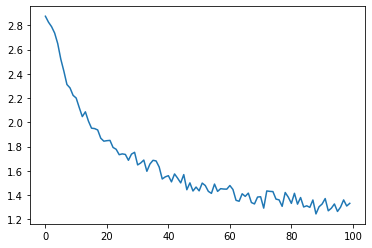

In [17]:
plt.plot(all_losses)
plt.show()

## Evaluating the Results

In [18]:
confusion = torch.zeros(n_languages, n_languages)
n_confusion = 10_000

In [19]:
def evaluate(name_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
        
    return output

In [20]:
for i in range(n_confusion):
    language, name, language_tensor, name_tensor = random_training_example()
    output = evaluate(name_tensor)
    
    guess, guess_index = language_from_output(output)
    language_index = languages.index(language)
    confusion[language_index][guess_index] += 1

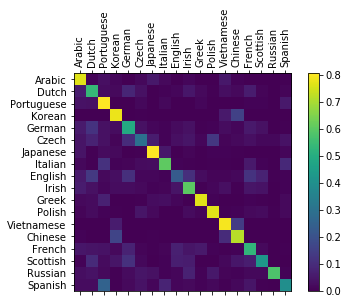

In [21]:
# Normalizes by dividing every row by its sum.
for i in range(n_languages):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)

# Plots a colored matrix
confusion_ax = ax.matshow(confusion.numpy())

# Color bar.
fig.colorbar(confusion_ax)

# Sets tick labels.
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

### Running on User Input

In [22]:
def predict(input_name, n_predictions=3):
    print("\n> %s" % input_name)
    with torch.no_grad():
        output = evaluate(name_to_tensor(input_name))
        
        top_value, top_index = output.topk(n_predictions, 1)
        
        for i in range(n_predictions):
            value = top_value[0][i].item()
            language_index = top_index[0][i].item()
            
            print("(%.2f) %s" % (value, languages[language_index]))
            
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.84) Czech
(-1.13) Russian
(-2.41) English

> Jackson
(-0.62) Scottish
(-1.33) English
(-2.50) Russian

> Satoshi
(-1.10) Arabic
(-1.16) Japanese
(-2.01) Italian
